# Simulation of the 1945 Makran Tsunami

The 1945 Makran Tsunami was a large tsunami which originated due to the 1945 Balochistan earthquake. The resulting tsunami is beielved to have killed around 4000 people along the coast of modern day Pakistan, India, Iran and Oman. Tidal records indicate that the tsunami was recorded as far as the islands of Seychells and Minicoy. Moden simulations of the tsunami indicate tsunami elevations would have been observed across the islands of the Maldives as well. 

Here we will model the tsunami using elevations from actual fault estimations.

<img src="Map of Region.png" style="height:1000px, width:1000px">

As usual we begin by importing the required python libraries and modules. 

In [1]:
%matplotlib notebook
from thetis import*
import scipy.interpolate
import pyproj

Next we will import the mesh. Additionally we will visualise the mesh as well using the firedrake plot utility function. The plot function provides an easy way to plot of firedrake functions.    

<IPython.core.display.Javascript object>


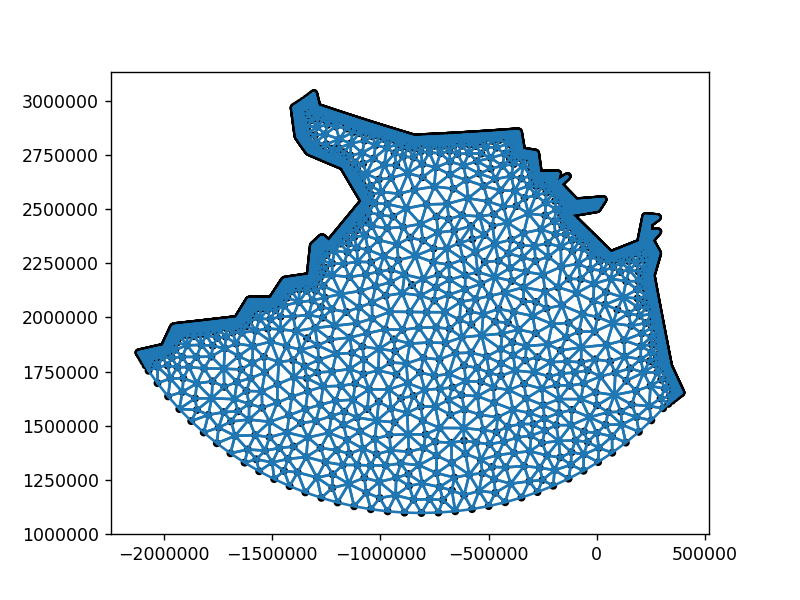

In [2]:
mesh = Mesh('Mesh/mesh.msh')
plot(mesh)

Next we will define the FunctionSpace. The functionspace is the place where our Functions will 'live'.

In [3]:
P1 = FunctionSpace(mesh, 'CG', 1)

Next we will define a bathymetry function. For the purpose of this simulation to keeps things simple we will assign a constant depth of 20m. Before creating the bathymetry function and assigning depth we will visualise the bathymetry of the area using GEBCO bathymetry dataset.              

<img src="Depth.png" style="height:1000px, width:1000px">

Now we will proceed with defining and assigning a depth using a bathymetry function, the bathymetry function will be defined within the FunctionSpace defined earlier. We will again visualise the depth to confirm if the value is assigned across the domain.

<IPython.core.display.Javascript object>


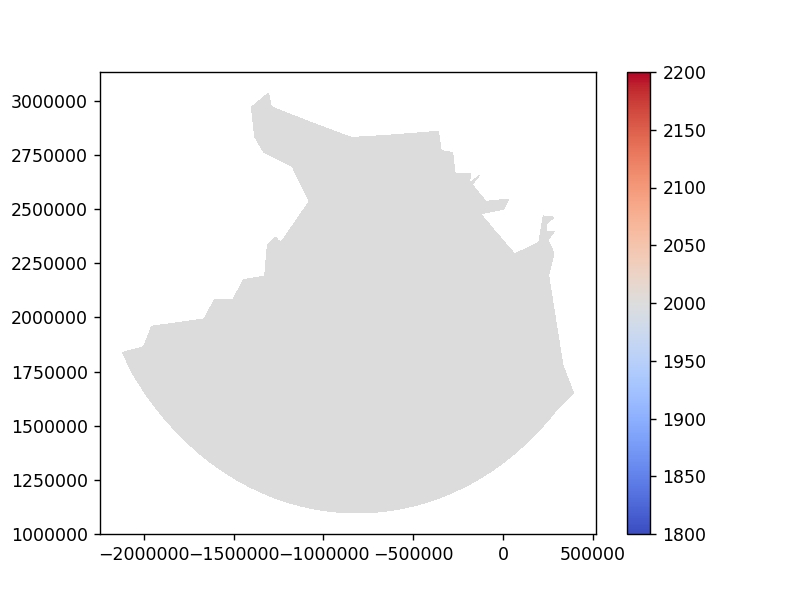

In [4]:
bathymetry_2d = Function(P1, name='Bathymetry')
depth = 2000.0
bathymetry_2d.assign(depth)

plot(bathymetry_2d)

Now we will define a function for the initial elevation, again in the same Functionspace. This initial elevation function will set the values for the initial elevation for our simulation. 

In [5]:
init_elev = Function(P1, name = 'init_elev')

After defining the initial elevation function we need to set the values of the function, across our mesh. We will do it in stages. First we will begin by accessing the co-ordinates of the mesh and the current values of the initial elevation function.

In [6]:
mesh_coordinates = mesh.coordinates.dat.data
init_elev_data = init_elev.dat.data

Next we will import the data that we wish to be interpolate onto the initial elevation function. Here the data that we wish to be interpolated on to our elevation function is the vertical displacement of the free-surface due to the earthquake. Given the earthquake fault parameters which is available from various sources such as USGS these deformations can be obtained through various means. Here we will use the output obtained from an 'Okada model' utilising single fault parameters as provided in Arjun.et.al. We will also take a look at the first row of the data, the columns are arranged as Longitude, Latitude, x, y and z dispalcement.

In [16]:
data = np.genfromtxt('outputs.txt')
#import numpy as np
#np.set_printoptions(suppress=True)
print (np.round(data[0],5))

[6.000e+01 1.500e+01 2.930e-03 1.914e-02 3.260e-03]


In order to interpolate the data values onto our mesh, we will use the scipy interpolator. First we create the interpolator. Note from above that the cordinates are given in the first two columns and the data values that we wish to interpolate (the surface elevations) are given in the fourth column.

In [8]:
intp = scipy.interpolate.NearestNDInterpolator(data[:,0:2], data[:,4])

Finally we are ready to interpolate. However since our mesh is in Universal Transverse Mercator coordinate system (UTM) coordinates and the data points are defined in World Geodetic System (WGS), we convert the data points to UTM, interpolate and set the value of the initial elevation function.

In [9]:
for i,xy in enumerate(mesh_coordinates):
    outproj = pyproj.Proj(init='epsg:4326')
    inproj = pyproj.Proj(init='epsg:32643') 
    lon, lat =pyproj.transform(inproj, outproj, xy[0], xy[1])
    init_elev_data[i] = intp(lon, lat)

If we wish to store the initial elevation as a hdf5 file wihch can be reloaded again, or wish to save the initial elevations as a pvd file which can be viewed. Additionally we will plot the initial elevation function to see if the values were set across the mesh.

<IPython.core.display.Javascript object>


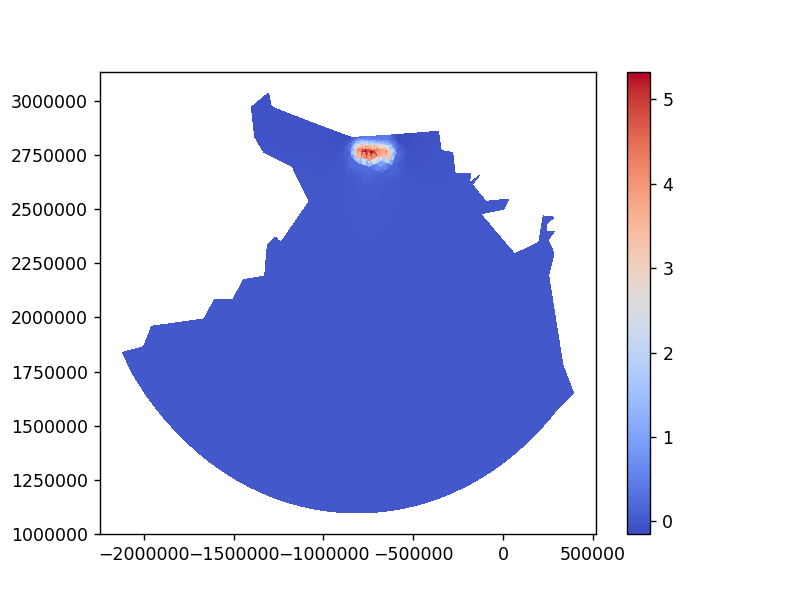

In [10]:
#To store as a hdf5 file, first define a dumbcheckpoint object and store the function.
#chk = DumbCheckpoint('init_elevation', mode=FILE_CREATE)
#chk.store(init_elev, name="init_elev")
#chk.close

# we save the values as a PVD file using a File object as below.(Note that the file suffix has to be .pvd. since firedrake saves in PVD format). 
#outfile = File("Initial_Elevation.pvd")
#outfile.write(init_elev)

#To plot the initial elevation function just call plot on the function as before.
plot (init_elev)

Now we define the total simulation time and the export times. The export time is when the simulation will export the stated parameters. 

In [11]:
# total duration in seconds
t_end = 3600.0*3
# export interval in seconds
t_export = 900.0

Now we are ready to create our solver and assign some options to run our model. We set the timesteppertype as CrankNicolson. We also define the timestep as 5 seconds.

In [12]:
solver_obj = solver2d.FlowSolver2d(mesh, bathymetry_2d)
options = solver_obj.options
#options.simulation_export_time = t_export
options.simulation_end_time = t_end
options.timestepper_type = 'CrankNicolson'
options.timestep = 5.0

Next we define the boundary conditions of our model. We will set the velocities at the coastlines and open boundaries to zero. The elevations at the open boudaries are also set to zero. 

In [13]:
solver_obj.bnd_functions['shallow_water'] = {
        100: {'un': 0.0},
        200: {'un': 0.0, 'elev' :0.0}
    }

Now we are ready to set the initial conditions of our simulation. We set the initial elevations of our simulation to the initial elevation function we created earlier. Additionally as we wish to visualise the simulation as it goes on we will define a function that will plot the elevation at certain time steps.

In [14]:
def update_forcings(t_new):
    uv, elev = solver_obj.fields.solution_2d.split()
    plot_time = [0,2000,4000,6000,8000,10000]
    for i in plot_time:
        if t_new == i:
            plot(elev)

solver_obj.assign_initial_conditions(elev=init_elev)

dt = 5.0
Using time integrator: CrankNicolson


Now set the solver iterator to start the simulation running.

    0     0 T=      0.00 eta norm: 477519.7838 u norm:     0.0000  0.00
    1    20 T=    100.00 eta norm: 445063.3377 u norm: 11585.1637 16.19
    2    40 T=    200.00 eta norm: 384747.3470 u norm: 18892.6326 14.38
    3    60 T=    300.00 eta norm: 346940.1492 u norm: 21853.3743 14.41
    4    80 T=    400.00 eta norm: 344592.5102 u norm: 21776.7740 14.61
    5   100 T=    500.00 eta norm: 348237.0929 u norm: 21212.8043 15.17
    6   120 T=    600.00 eta norm: 330034.0198 u norm: 22292.3289 14.28
    7   140 T=    700.00 eta norm: 294376.5753 u norm: 24290.7892 14.88
    8   160 T=    800.00 eta norm: 266824.5097 u norm: 25456.0640 14.91
    9   180 T=    900.00 eta norm: 262687.6283 u norm: 25331.3629 14.78
   10   200 T=   1000.00 eta norm: 272766.0866 u norm: 24525.5972 14.45
   11   220 T=   1100.00 eta norm: 282033.8852 u norm: 23756.9763 15.00
   12   240 T=   1200.00 eta norm: 284976.9693 u norm: 23263.0950 14.38
   13   260 T=   1300.00 eta norm: 285059.2735 u norm: 22851.445

<IPython.core.display.Javascript object>


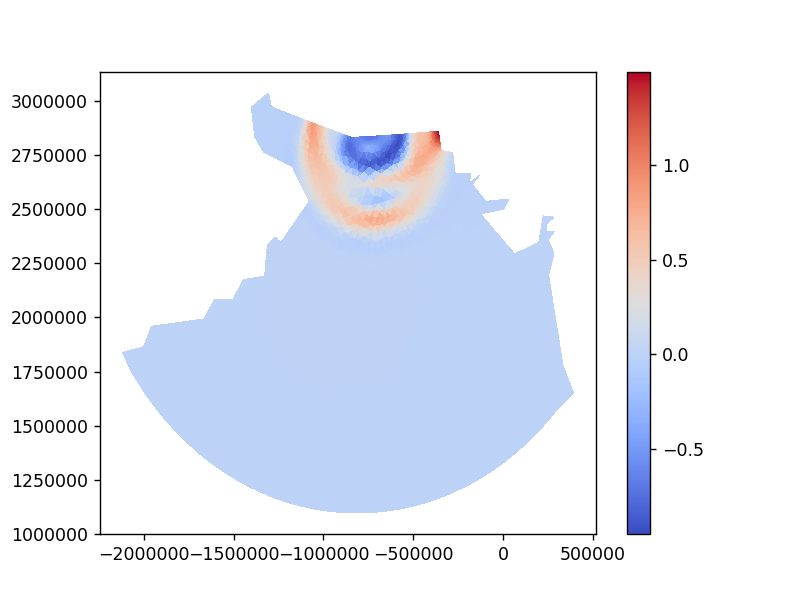

   20   400 T=   2000.00 eta norm: 286923.2001 u norm: 20645.6853 17.70
   21   420 T=   2100.00 eta norm: 290428.8107 u norm: 20187.1173 14.72
   22   440 T=   2200.00 eta norm: 293176.5906 u norm: 19814.2080 15.77
   23   460 T=   2300.00 eta norm: 294126.0850 u norm: 19563.0538 15.55
   24   480 T=   2400.00 eta norm: 294172.6925 u norm: 19358.5158 15.38
   25   500 T=   2500.00 eta norm: 294439.5606 u norm: 19138.2558 14.38
   26   520 T=   2600.00 eta norm: 294937.2057 u norm: 18923.3202 15.50
   27   540 T=   2700.00 eta norm: 294953.2945 u norm: 18771.5097 14.38
   28   560 T=   2800.00 eta norm: 293932.0872 u norm: 18715.0432 15.00
   29   580 T=   2900.00 eta norm: 291582.9181 u norm: 18763.3194 14.55
   30   600 T=   3000.00 eta norm: 287799.4023 u norm: 18917.3038 14.83
   31   620 T=   3100.00 eta norm: 282799.2046 u norm: 19160.7556 14.88
   32   640 T=   3200.00 eta norm: 277066.2760 u norm: 19459.9203 15.09
   33   660 T=   3300.00 eta norm: 271054.9265 u norm: 19780.113

<IPython.core.display.Javascript object>


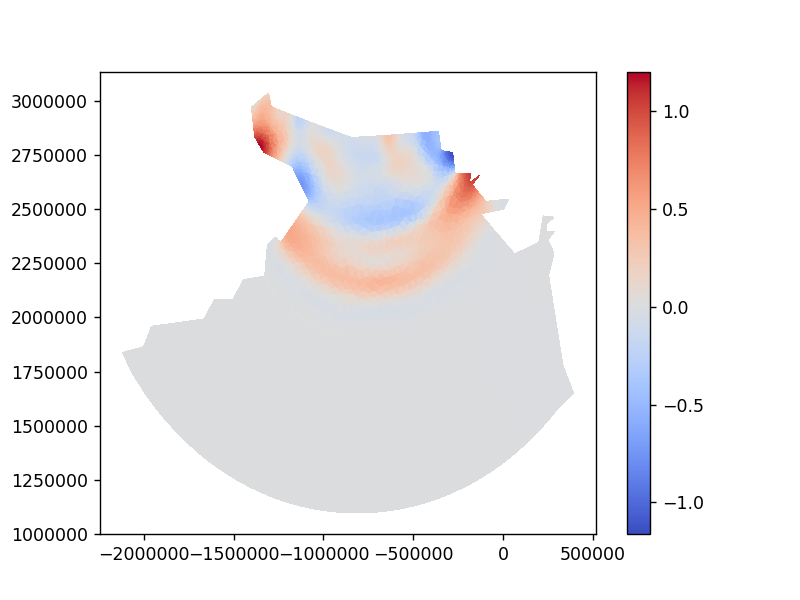

   40   800 T=   4000.00 eta norm: 268584.2523 u norm: 19456.6655 16.22
   41   820 T=   4100.00 eta norm: 275148.0653 u norm: 18927.6159 14.70
   42   840 T=   4200.00 eta norm: 280580.7678 u norm: 18441.6850 15.08
   43   860 T=   4300.00 eta norm: 283601.0179 u norm: 18105.3104 14.70
   44   880 T=   4400.00 eta norm: 283516.9130 u norm: 17988.9701 14.83
   45   900 T=   4500.00 eta norm: 280554.5905 u norm: 18082.9768 15.20
   46   920 T=   4600.00 eta norm: 275703.0440 u norm: 18306.8617 15.53
   47   940 T=   4700.00 eta norm: 270272.8655 u norm: 18555.7925 15.12
   48   960 T=   4800.00 eta norm: 265490.2724 u norm: 18739.7602 15.78
   49   980 T=   4900.00 eta norm: 262331.6541 u norm: 18792.5596 14.80
   50  1000 T=   5000.00 eta norm: 261366.3831 u norm: 18672.9050 16.00
   51  1020 T=   5100.00 eta norm: 262418.6394 u norm: 18381.7864 13.88
   52  1040 T=   5200.00 eta norm: 264504.3512 u norm: 17976.2797 14.41
   53  1060 T=   5300.00 eta norm: 266311.9974 u norm: 17555.401

<IPython.core.display.Javascript object>


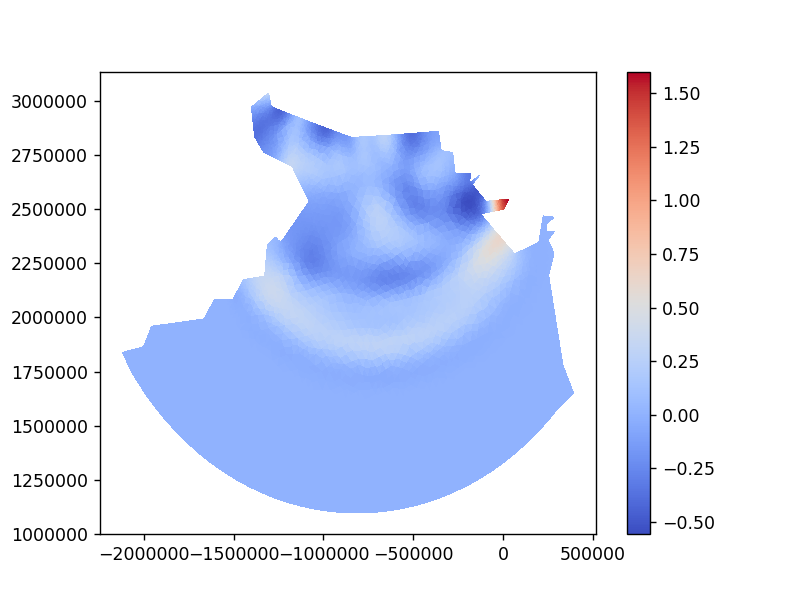

   60  1200 T=   6000.00 eta norm: 235919.8146 u norm: 18441.0444 18.47
   61  1220 T=   6100.00 eta norm: 229901.8072 u norm: 18767.4802 14.41
   62  1240 T=   6200.00 eta norm: 225458.7064 u norm: 18995.1949 13.89
   63  1260 T=   6300.00 eta norm: 222894.4985 u norm: 19109.9768 15.59
   64  1280 T=   6400.00 eta norm: 222346.1687 u norm: 19105.1641 14.97
   65  1300 T=   6500.00 eta norm: 223834.0728 u norm: 18976.1907 13.84
   66  1320 T=   6600.00 eta norm: 227187.3988 u norm: 18724.7997 14.41
   67  1340 T=   6700.00 eta norm: 231937.5837 u norm: 18368.3709 15.20
   68  1360 T=   6800.00 eta norm: 237373.8598 u norm: 17942.8589 14.78
   69  1380 T=   6900.00 eta norm: 242788.4416 u norm: 17493.1796 13.83
   70  1400 T=   7000.00 eta norm: 247685.5744 u norm: 17059.7750 14.59
   71  1420 T=   7100.00 eta norm: 251779.0220 u norm: 16673.9471 13.81
   72  1440 T=   7200.00 eta norm: 254880.9883 u norm: 16360.5506 14.66
   73  1460 T=   7300.00 eta norm: 256882.7873 u norm: 16136.248

<IPython.core.display.Javascript object>


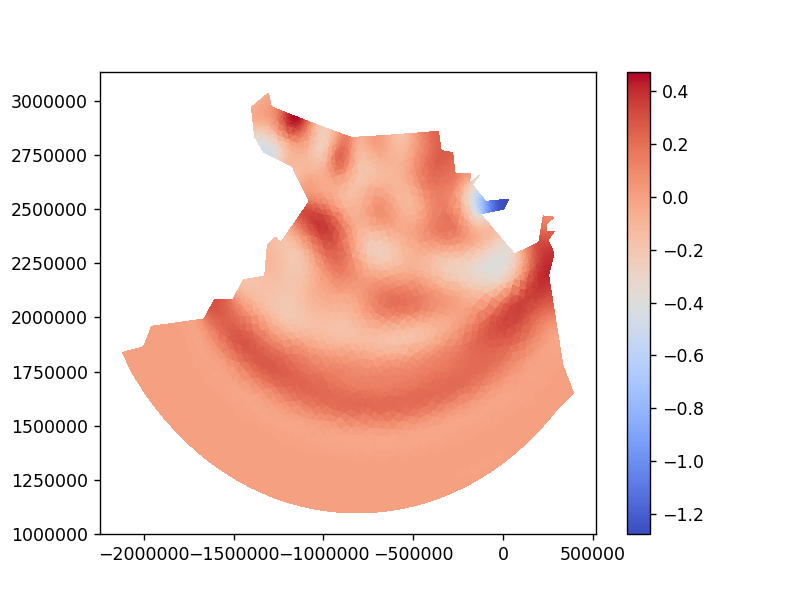

   80  1600 T=   8000.00 eta norm: 250117.3380 u norm: 16352.4602 16.50
   81  1620 T=   8100.00 eta norm: 247230.8091 u norm: 16533.8239 15.50
   82  1640 T=   8200.00 eta norm: 244388.9609 u norm: 16708.5787 15.53
   83  1660 T=   8300.00 eta norm: 241857.3012 u norm: 16858.2416 14.50
   84  1680 T=   8400.00 eta norm: 239808.7072 u norm: 16971.9846 14.52
   85  1700 T=   8500.00 eta norm: 238243.1323 u norm: 17051.0288 14.92
   86  1720 T=   8600.00 eta norm: 236963.2424 u norm: 17109.3815 16.31
   87  1740 T=   8700.00 eta norm: 235669.6496 u norm: 17167.1799 14.69
   88  1760 T=   8800.00 eta norm: 234141.8848 u norm: 17238.8052 15.70
   89  1780 T=   8900.00 eta norm: 232390.1242 u norm: 17323.2774 14.92
   90  1800 T=   9000.00 eta norm: 230681.7225 u norm: 17403.2540 14.81
   91  1820 T=   9100.00 eta norm: 229436.4334 u norm: 17452.3413 14.11
   92  1840 T=   9200.00 eta norm: 229061.6281 u norm: 17445.1927 15.41
   93  1860 T=   9300.00 eta norm: 229812.1539 u norm: 17365.190

<IPython.core.display.Javascript object>


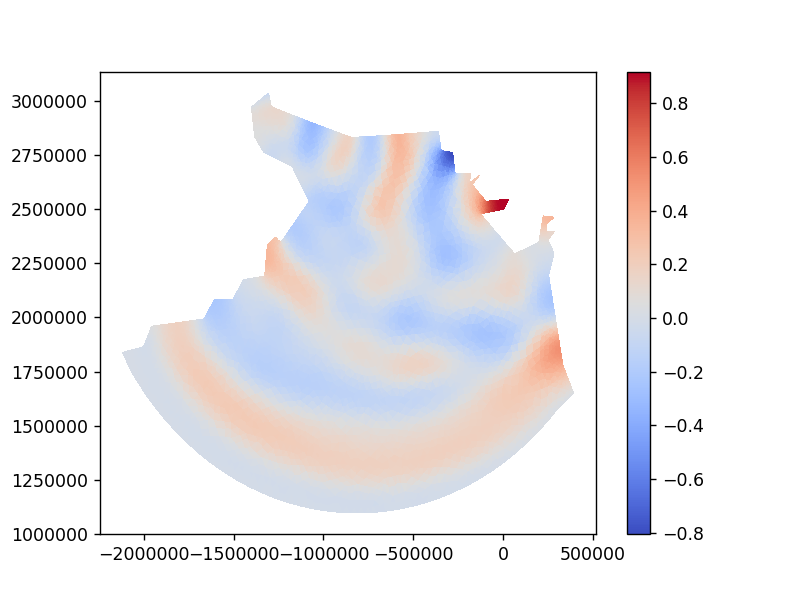

  100  2000 T=  10000.00 eta norm: 246900.8844 u norm: 15929.2476 18.38
  101  2020 T=  10100.00 eta norm: 246366.3194 u norm: 15936.2309 16.33
  102  2040 T=  10200.00 eta norm: 244562.8946 u norm: 16035.6375 15.75
  103  2060 T=  10300.00 eta norm: 241607.0235 u norm: 16212.4360 16.58
  104  2080 T=  10400.00 eta norm: 237711.6868 u norm: 16443.3717 16.22
  105  2100 T=  10500.00 eta norm: 233186.5420 u norm: 16698.9540 17.62
  106  2120 T=  10600.00 eta norm: 228422.5184 u norm: 16946.0484 15.17
  107  2140 T=  10700.00 eta norm: 223851.9017 u norm: 17151.3599 15.70
  108  2160 T=  10800.00 eta norm: 219882.2227 u norm: 17285.4724 15.22


In [15]:
%timeit
solver_obj.iterate(update_forcings=update_forcings)